# Histogram of Oriented Gradients

## Data loading and preparation

In [ ]:
#importing required libraries
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler  # To transform the dataset
from sklearn.cluster import KMeans                # To instantiate, train and use model
from sklearn import metrics    
from scipy import spatial
import numpy as np
from numpy import dot
from numpy.linalg import norm
import os
import os.path
import time

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


Unzipping the competition test dataset

In [ ]:
!unzip -q /content/drive/MyDrive/datasets/challenge_test_data.zip

In [ ]:
GALLERY_PATH = "/content/gallery"
QUERY_PATH = "/content/query"

Defining a function to load images, transform them in black and white and resize them in a specific format.

In [ ]:
def load_image(path):
    img = imread(path, plugin = "matplotlib", as_gray = True)
    resized_img = resize(img, (128, 64)) # HOG accepts only these dimensions
    return resized_img

## Loading the images

In [ ]:
image_extensions = ['.jpg', '.png', '.jpeg']   # case-insensitive (upper/lower doesn't matter)

gallery_images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(GALLERY_PATH) for f in filenames if os.path.splitext(f)[1].lower() in image_extensions]
print("%d gallery images to analyze" % len(gallery_images))

6355 gallery images to analyze


In [ ]:
query_images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(QUERY_PATH) for f in filenames if os.path.splitext(f)[1].lower() in image_extensions]
print("%d query images to analyze" % len(query_images))

65 query images to analyze


## Extracting the features from the images

To extract the feature vectors, we loop for each image and we do the extraction with the function hog, from the library scikit-image. Basically, it works like this:
1) The image is split in a series of 8x8 cells. Since it is a 128x64 image, we have 16x8 of such cells.

2) For each cell we compute the gradient (with magnitude and orientation) of each pixel.

3) We then create a histogram of 9 bins and we count the various gradients that go into each bin. The bins are 0-20°/20°-40°/.../160°-180°. Therefore, for each cell we end up with a 9-element vector corresponding to the values of each bin.

4) We define a block as a 2x2 window of cells. A block, therefore, is composed of a 36-element vector (9x4). We move this window with a stride = 1. This means that we will have a total of 7x15 possible blocks, each one with a 36-element vector.

5) Our final feature vector for each image will be then of length 7x15x36 = 3780

We append each feature vector in the list query_features and gallery_features, respectively. They will be converted to numpy arrays.

In [ ]:
tic = time.clock()
query_features = []
for i, image_path in enumerate(query_images):
    if i % 500 == 0:
        toc = time.clock()
        elap = toc-tic;
        print("analyzing image %d / %d. Time: %4.4f seconds." % (i, len(query_images),elap))
        tic = time.clock()
    img = load_image(image_path)
    fd, hog_image = hog(img, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), visualize=True, multichannel=False)
    query_features.append(fd)
query_features = np.array(query_features)
print('finished extracting features for %d images' % len(query_images))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


analyzing image 0 / 65. Time: 0.0006 seconds.
finished extracting features for 65 images


In [ ]:
tic = time.clock()
gallery_features = []
for i, image_path in enumerate(gallery_images):
    if i % 500 == 0:
        toc = time.clock()
        elap = toc-tic;
        print("analyzing image %d / %d. Time: %4.4f seconds." % (i, len(gallery_images),elap))
        tic = time.clock()
    img = load_image(image_path)
    fd, hog_image = hog(img, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), visualize=True, multichannel=False)
    gallery_features.append(fd)
gallery_features = np.array(gallery_features)
print('finished extracting features for %d images' % len(gallery_images))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


analyzing image 0 / 65. Time: 0.0006 seconds.
analyzing image 500 / 65. Time: 55.6489 seconds.
analyzing image 1000 / 65. Time: 56.8701 seconds.
analyzing image 1500 / 65. Time: 55.9276 seconds.
analyzing image 2000 / 65. Time: 61.7565 seconds.
analyzing image 2500 / 65. Time: 60.1643 seconds.
analyzing image 3000 / 65. Time: 60.0279 seconds.
analyzing image 3500 / 65. Time: 60.1053 seconds.
analyzing image 4000 / 65. Time: 65.2719 seconds.
analyzing image 4500 / 65. Time: 62.6852 seconds.
analyzing image 5000 / 65. Time: 57.3904 seconds.
analyzing image 5500 / 65. Time: 56.6770 seconds.
analyzing image 6000 / 65. Time: 57.1035 seconds.
finished extracting features for 6355 images


## Return similar images

We now define two function to return similar images, using both cosine distance and euclidean distance. We basically compute the difference according to these metrics between the query feature vector and all the gallery feature vectors. We find the closest images, we sort them and return the first 10.
Then, since we want to return a dictionary, we create an ad-hoc function to do so.

In [ ]:
def get_closest_images_cosine(query_image_idx, num_results=10):
    distances = [ distance.cosine(query_features[query_image_idx], feat) for feat in gallery_features]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[:num_results]
    return idx_closest

def get_closest_images_euclidean(query_image_idx, num_results=10):
    distances = [ distance.euclidean(query_features[query_image_idx], feat) for feat in gallery_features]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[:num_results]
    return idx_closest

In [ ]:
def get_closest_dict(query_images, gallery_images, distance = 'cosine'):
  res = {}
  for i in range(len(query_images)):

    if distance == 'euclidean':
      idx_closest = get_closest_images_euclidean(i)
    else:
      idx_closest = get_closest_images_cosine(i)
      
    closest_images_list = [gallery_images[idx] for idx in idx_closest]
    res[query_images[i]] = closest_images_list

  return res


In [ ]:
dizionario = get_closest_dict(query_images, gallery_images, 'euclidean')


In [ ]:
from pprint import pprint
pprint(dizionario)

{'/content/query/013c80f43deff8d61b6a2021f9b0a335665fdd1f.jpg': ['/content/gallery/568a9dbbaaa534dbe3ff3129a15b70919d6b1909.jpg',
                                                                 '/content/gallery/fa6bb036240952722af17b606851a91df0724f5b.jpg',
                                                                 '/content/gallery/753604b63d559d50b074e802b81addb7510c1e09.jpg',
                                                                 '/content/gallery/7e9738e35bda9222fdc76c62885d503e871e0ea6.jpg',
                                                                 '/content/gallery/f9391118dd87c728cdc89d8754658a9ce28fdbec.jpg',
                                                                 '/content/gallery/8947be7a0a18c4a3fa233e7c4276eaf424e28fcf.jpg',
                                                                 '/content/gallery/d39ee97dfb9624c7d2666b73cf29bad8677cf9ef.jpg',
                                                                 '/content/gallery/c5ccad6

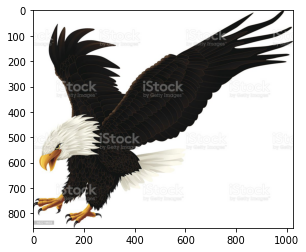

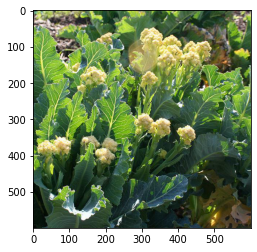

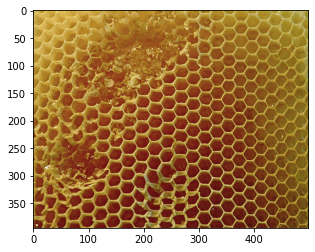

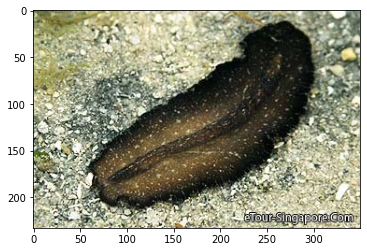

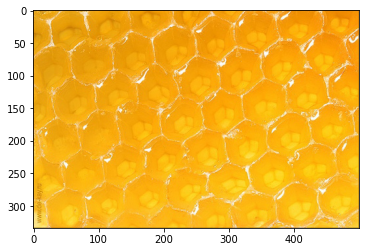

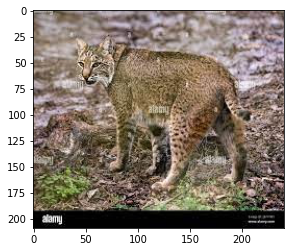

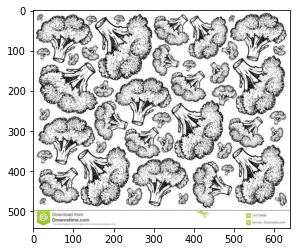

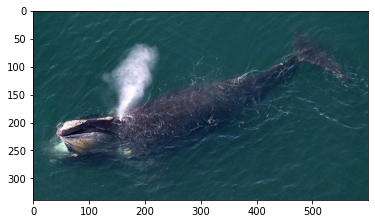

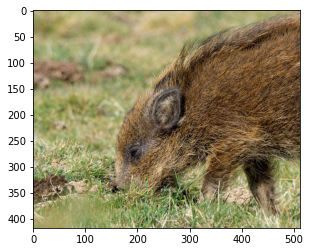

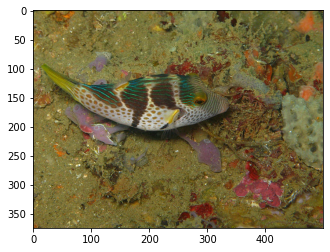

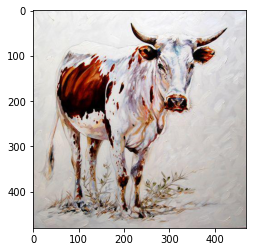

In [ ]:
plt.imshow(plt.imread('/content/query/013c80f43deff8d61b6a2021f9b0a335665fdd1f.jpg'))
plt.show()
print('\n\n')

for similar_image in dizionario['/content/query/013c80f43deff8d61b6a2021f9b0a335665fdd1f.jpg']:
  plt.imshow(plt.imread(similar_image))
  plt.show()
  print('\n\n')